In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import Dataset
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler

In [64]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_idx = {label: idx for idx, label in enumerate(sorted(set(self.data["label"])))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = torch.tensor(self.data.iloc[idx, 2:-1], dtype=torch.float32)
        label = torch.tensor(self.label_idx[self.data.iloc[idx][-1]])
        
        if self.transform:
            input = self.transform(input)

        return input, label
    
def get_dataloader(path):
    trainset = CustomDataset(path)

    # Split into train and validation
    indices = list(range(len(trainset)))
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices)
    split = int(len(indices) * 0.8) #split at 80%

    # split into training and validation indices
    train_indices, val_indices = indices[:split], indices[split:]  
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=1, num_workers=1, sampler=val_sampler)
    return train_loader, val_loader

In [65]:
# Fixed PyTorch random seed for reproducible result
torch.manual_seed(123)

# classes = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
path = "../Data/features_30_sec.csv"
train_loader, val_loader = get_dataloader(path)

In [66]:
len(train_loader), len(val_loader)

(800, 200)

In [67]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        name: name of the model
        batch_size: size of the batch used during training
        learning_rate: learning rate value used during training
        epoch: epoch value
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format( name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
    return path

In [84]:
class BaselineModel(nn.Module):
    """
        A very basic baseline model
    """
    def __init__(self) -> None:
        super(BaselineModel, self).__init__()
        self.name = "baseline"
        self.fc1 = nn.Linear(57, 100)
        self.fc2 = nn.Linear(100, 250)
        self.fc3 = nn.Linear(250, 40)
        self.fc4 = nn.Linear(40, 10) # Classify between 10 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def train(self, train_loader, val_loader, batch_size=1, learning_rate=0.01, num_epochs=10):
        ########################################################################
        # Define the Loss function and optimizer
        # The loss function will be Cross Entropy.
        # Optimizer will be SGD with Momentum.
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        ########################################################################
        # Set up some numpy arrays to store the training/test loss/erruracy
        train_err = np.zeros(num_epochs)
        train_loss = np.zeros(num_epochs)
        val_err = np.zeros(num_epochs)
        val_loss = np.zeros(num_epochs)
        ########################################################################
        # Train the network
        # Loop over the data iterator and sample a new batch of training data
        # Get the output from the network, and optimize our loss function.
        start_time = time.time()
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            total_train_loss = 0.0
            total_train_err = 0.0
            total_epoch = 0
            for i, data in enumerate(train_loader, 0):
                # Get the inputs
                inputs, labels = data
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward pass, backward pass, and optimize
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # Calculate the statistics
                corr = (torch.argmax(outputs,1) == labels)
                total_train_err += int(corr.sum())
                total_train_loss += loss.item()
                total_epoch += len(labels)
            train_err[epoch] = float(total_train_err) / total_epoch
            train_loss[epoch] = float(total_train_loss) / (i+1)
            val_err[epoch], val_loss[epoch] = self.evaluate(val_loader, criterion)
            print(("Epoch {}: Train err: {}, Train loss: {} |"+
                "Validation err: {}, Validation loss: {}").format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
        # Save the trained model to a file
        model_path = get_model_name(self.name, batch_size, learning_rate, epoch)
        torch.save(self.state_dict(), model_path)
        print('Finished Training')
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
        # Write the train/test loss/err into CSV file for plotting later
        np.savetxt("{}_train_err.csv".format(model_path), train_err)
        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_val_err.csv".format(model_path), val_err)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    def evaluate(self, loader, criterion):
        """ Evaluate the network on the validation set.

        Args:
            loader: PyTorch data loader for the validation set
            criterion: The loss function
        Returns:
            err: A scalar for the avg classification error over the validation set
            loss: A scalar for the average loss function over the validation set
        """
        total_loss = 0.0
        total_err = 0.0
        total_epoch = 0
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            corr = (torch.argmax(outputs,1) == labels)
            total_err += int(corr.sum())
            total_loss += loss.item()
            total_epoch += len(labels)
        err = float(total_err) / total_epoch
        loss = float(total_loss) / (i + 1)
        return err, loss

baseline = BaselineModel()

In [87]:
batch_size=1
learning_rate=0.0001
num_epochs=30

baseline.train(train_loader, val_loader, batch_size, learning_rate, num_epochs)

Epoch 1: Train err: 0.09875, Train loss: nan |Validation err: 0.105, Validation loss: nan
Epoch 2: Train err: 0.09875, Train loss: nan |Validation err: 0.105, Validation loss: nan
Epoch 3: Train err: 0.09875, Train loss: nan |Validation err: 0.105, Validation loss: nan
Epoch 4: Train err: 0.09875, Train loss: nan |Validation err: 0.105, Validation loss: nan


KeyboardInterrupt: 

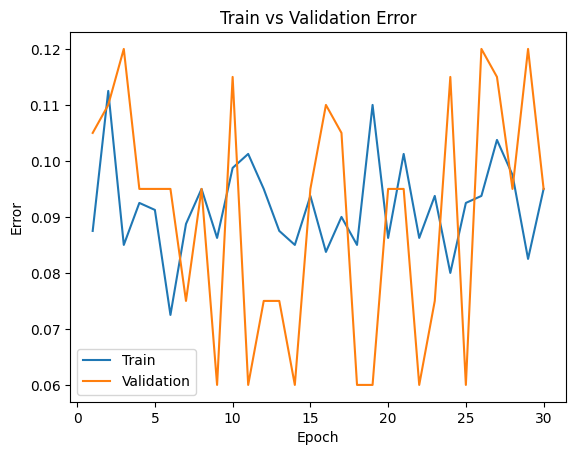

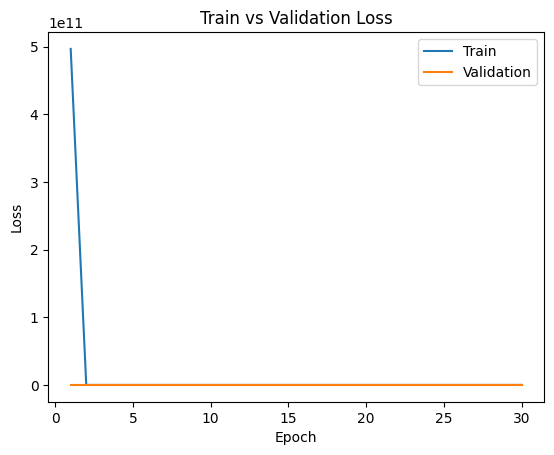

In [83]:
model_path = get_model_name("baseline", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

In [86]:
baseline = BaselineModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline.parameters(), lr=0.01, momentum=0.9)
tot = 0
for i, data in enumerate(train_loader, 0):
    # Get the inputs
    inputs, labels = data
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward pass, backward pass, and optimize
    outputs = baseline(inputs)
    # print(inputs)
    print(outputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()
    # Calculate the statistics
    corr = (torch.argmax(outputs,1) == labels)
    print(torch.argmax(outputs,1), labels)
    tot += int(corr.sum())
    if i > 100:
        print(tot/100)
        break

tensor([[  7590.6533,  10735.1953, -17548.0859,  -8087.1284,   3358.7861,
         -11509.4658,  13388.4648,  -5614.0308,   3714.3430,   3982.3130]],
       grad_fn=<AddmmBackward0>)
tensor([6]) tensor([3])
tensor([[ 1.0551e+14,  1.4086e+14, -2.7043e+13,  2.5370e+17,  1.5041e+14,
         -6.2889e+13, -2.5368e+17,  6.5786e+13, -3.8240e+12, -1.1363e+14]],
       grad_fn=<AddmmBackward0>)
tensor([3]) tensor([1])
tensor([[ 6.3443e+03,  4.8601e+13, -1.9823e+04, -4.8601e+13, -9.2209e+03,
         -2.1319e+03,  1.2957e+04,  1.8841e+03,  1.5644e+04, -1.6800e+04]],
       grad_fn=<AddmmBackward0>)
tensor([1]) tensor([2])
tensor([[ 2.5930e+08,  2.2942e+22, -6.6453e+07, -2.2942e+22,  3.6971e+08,
         -1.5458e+08, -1.6890e+12,  1.6166e+08, -9.3957e+06, -2.7928e+08]],
       grad_fn=<AddmmBackward0>)
tensor([1]) tensor([5])
tensor([[ 3.2943e+12, -8.3385e+15, -2.8525e+12,  3.9281e+12,  3.0902e+12,
          8.3369e+15, -6.2200e+12, -2.4935e+12, -1.0886e+11,  3.6140e+12]],
       grad_fn=<AddmmB